In [1]:
import utils
from constellation_scheduling import convert_constellation_scheduling

from astropy import units as u
import numpy as np

import networkx as nx

import plotly.graph_objects as go

from plotly.subplots import make_subplots

import plotly.io as pio
pio.renderers.default="notebook_connected"

from poliastro.bodies import Earth, Mars, Sun
from poliastro.twobody import Orbit
from poliastro.plotting import *
from poliastro.examples import *

Using Python-MIP package version 1.6.8


In [256]:
N = 2
r = {}
v = {}
r[0] = [-6045, -3490, 2500] * u.km
r[1] = -1*r[0]
v[0] = [-3.457, 6.618, 2.533] * u.km / u.s
v[1] = -1*v[0]
# print(v[0])
# print(v[1])
# r = [-6045, -3490, 2500] * u.km
# v = [-3.457, 6.618, 2.533] * u.km / u.s
ss = {}
ss[0] = Orbit.from_vectors(Earth, r[0], v[0])
ss[1] = Orbit.from_vectors(Earth, r[1], v[1])

# Problem Parameters
t_window = 20.0
num_t_step = 100
t_step = t_window/num_t_step
t_unit = u.min
# num_t_step = int(t_window/t_step)
t_arr = np.linspace(0, t_window, num_t_step)

orbit_start_time = 180

print(num_t_step)

r_e = 6378.0
# a = 1150.0
a = r_e
r_s = a + r_e
# Globals
Earth_radius = r_e * u.km

# Phase 1
# Inital Deployment

a_1_init = r_s * u.km
ecc_1_init = 0 * u.one

num_plane_1_init = 4
num_sat_1_init = 4

inc_1_init = 53 * u.deg

raan_range = [-180, 180]
raan_1_init = np.linspace(raan_range[0],raan_range[1], num_plane_1_init, endpoint=False)

argp_range = [0, 360]
argp_1_init = np.linspace(argp_range[0],argp_range[1], num_sat_1_init, endpoint=False)

sl_orbit_1_init = {}
locations = {}
for p in range(num_plane_1_init):
    for s in range(num_sat_1_init):
        sl_orbit_1_init[p, s] = Orbit.from_classical(Earth, \
                                                     a_1_init, \
                                                     ecc_1_init, \
                                                     inc_1_init, \
                                                     raan_1_init[p] * u.deg, \
                                                     argp_1_init[s] * u.deg, \
                                                     0.0 * u.deg)
        for t in range(0, num_t_step):
            locations[p, s, t] = sl_orbit_1_init[p, s].propagate((t_arr[t] + orbit_start_time) * t_unit).r
        print((p,s))

            

100
(0, 0)
(0, 1)
(0, 2)
(0, 3)
(1, 0)
(1, 1)
(1, 2)
(1, 3)
(2, 0)
(2, 1)
(2, 2)
(2, 3)
(3, 0)
(3, 1)
(3, 2)
(3, 3)


In [257]:
print(raan_1_init)
print(argp_1_init)

[-180.  -90.    0.   90.]
[  0.  90. 180. 270.]


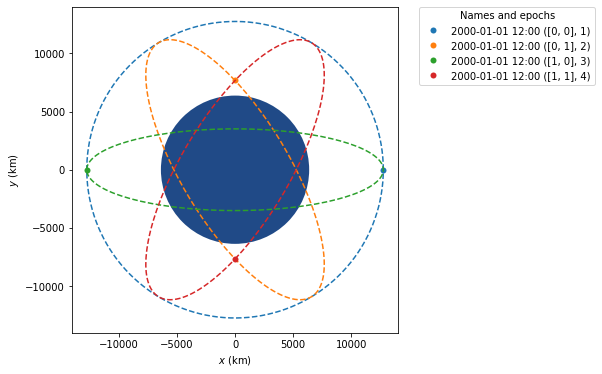

In [258]:
# frame = OrbitPlotter3D()
frame = StaticOrbitPlotter()
# ----- Four Satelites in Four Planes ------
# frame.plot(sl_orbit_1_init[0, 0], label="[0, 0], 1")
# frame.plot(sl_orbit_1_init[0, 1], label="[0, 1], 2")
# frame.plot(sl_orbit_1_init[0, 2], label="[0, 2], 3")
# frame.plot(sl_orbit_1_init[0, 3], label="[0, 3], 4")

# frame.plot(sl_orbit_1_init[1, 0], label="[1, 0], 5")
# frame.plot(sl_orbit_1_init[1, 1], label="[1, 1], 6")
# frame.plot(sl_orbit_1_init[1, 2], label="[1, 2], 7")
# frame.plot(sl_orbit_1_init[1, 3], label="[1, 3], 8")

# frame.plot(sl_orbit_1_init[2, 0], label="[2, 0], 9")
# frame.plot(sl_orbit_1_init[2, 1], label="[2, 1], 10")
# frame.plot(sl_orbit_1_init[2, 2], label="[2, 2], 11")
# frame.plot(sl_orbit_1_init[2, 3], label="[2, 3], 12")

# frame.plot(sl_orbit_1_init[3, 0], label="[3, 0], 13")
# frame.plot(sl_orbit_1_init[3, 1], label="[3, 1], 14")
# frame.plot(sl_orbit_1_init[3, 2], label="[3, 2], 15")
# frame.plot(sl_orbit_1_init[3, 3], label="[3, 3], 16")
# ----- Two Satelites in Two Planes ------
frame.plot(sl_orbit_1_init[0, 0], label="[0, 0], 1")
frame.plot(sl_orbit_1_init[1, 0], label="[0, 1], 2")
frame.plot(sl_orbit_1_init[2, 0], label="[1, 0], 3")
frame.plot(sl_orbit_1_init[3, 0], label="[1, 1], 4")


In [259]:
max_comm_range = 2*np.sqrt(np.power(r_s, 2) - np.power(r_e, 2))
S = num_plane_1_init*num_sat_1_init

# Let's use SSDs as a starting point, target 20 GB/second, vs 1 GB/second for the links, let's assume nominal distance of 4000.0 km
self_dist_normalization = 200.0
differences = np.zeros((num_plane_1_init, num_sat_1_init, num_plane_1_init, num_sat_1_init, num_t_step, 3))
distances = np.zeros((S, S, num_t_step))

for t in range(0, num_t_step):
    for p1 in range(0, num_plane_1_init):
        for s1 in range(0, num_sat_1_init):
            for p2 in range(0, num_plane_1_init):
                for s2 in range(0, num_sat_1_init):
#                     print(locations[p1, s1, t])
                    differences[p1][s1][p2][s2][t] = locations[p1, s1, t] - locations[p2, s2, t]
                    i = p1*num_sat_1_init + s1
                    j = p2*num_sat_1_init + s2
                    distances[i, j, t] = np.linalg.norm(differences[p1][s1][p2][s2][t])
                    if i == j:
                        distances[i, j, t] = self_dist_normalization
# print(np.amax((np.amax(distances,axis=2) <= max_comm_range), axis=1))
A_S = np.zeros((S, S))
for i in range(S):
    for j in range(S):
#         if np.max(distances[i, j, :]) <= max_comm_range and i != j:
        if np.max(distances[i, j, :]) <= max_comm_range:
            A_S[i, j] = 1
            A_S[j, i] = 1
            
# No self-connection for fre

np.sum(A_S, axis=1)
G_A_S = nx.to_networkx_graph(A_S, create_using=nx.DiGraph)
# print(G_A_S.edges)

In [260]:
print(max_comm_range)
print(A_S)
# np.max(distances[1, 2, :])

22094.040101348597
[[1. 1. 0. 1. 1. 0. 0. 1. 1. 0. 1. 1. 1. 1. 0. 0.]
 [1. 1. 1. 0. 1. 1. 0. 1. 0. 0. 1. 1. 0. 1. 1. 1.]
 [0. 1. 1. 1. 0. 1. 1. 0. 1. 1. 1. 0. 0. 0. 1. 1.]
 [1. 0. 1. 1. 0. 1. 1. 1. 1. 1. 0. 0. 1. 1. 0. 1.]
 [1. 1. 0. 0. 1. 1. 0. 1. 1. 0. 0. 1. 1. 0. 1. 1.]
 [0. 1. 1. 1. 1. 1. 1. 0. 1. 1. 0. 1. 0. 0. 1. 1.]
 [0. 0. 1. 1. 0. 1. 1. 1. 0. 1. 1. 0. 1. 1. 1. 0.]
 [1. 1. 0. 1. 1. 0. 1. 1. 0. 1. 1. 1. 1. 1. 0. 0.]
 [1. 0. 1. 1. 1. 1. 0. 0. 1. 1. 0. 1. 1. 0. 0. 1.]
 [0. 0. 1. 1. 0. 1. 1. 1. 1. 1. 1. 0. 1. 1. 0. 1.]
 [1. 1. 1. 0. 0. 0. 1. 1. 0. 1. 1. 1. 0. 1. 1. 0.]
 [1. 1. 0. 0. 1. 1. 0. 1. 1. 0. 1. 1. 0. 1. 1. 1.]
 [1. 0. 0. 1. 1. 0. 1. 1. 1. 1. 0. 0. 1. 1. 0. 1.]
 [1. 1. 0. 1. 0. 0. 1. 1. 0. 1. 1. 1. 1. 1. 1. 0.]
 [0. 1. 1. 0. 1. 1. 1. 0. 0. 0. 1. 1. 0. 1. 1. 1.]
 [0. 1. 1. 1. 1. 1. 0. 0. 1. 1. 0. 1. 1. 0. 1. 1.]]


In [261]:
utils.plot_circ_digraph(A=A_S)

In [262]:
distances_fig= go.Figure()
for i in range(S):
    for j in range(S):
        distances_fig.add_trace(go.Scatter(x=t_arr, y=distances[i, j, :], name=r'$d_{%i,%i}$' % (i+1, j+1)))
distances_fig.show()

In [263]:
B = 1
gamma = 1
# No = 1
# P_t = 100000
PNR = 1000

In [264]:
T = 5
# T = 2
A_T = np.zeros((T, T))
A_T[0, 1] = 1
A_T[0, 2] = 1
A_T[1, 3] = 1
A_T[2, 3] = 1
A_T[2, 4] = 1


out_proc_ratio = 0.05
out_mean = 1.0

out_size_range = 0.5/T
out_size_base = out_mean/T
out_size = np.zeros(T)


proc_time_range = 0.5/T
proc_time_base = out_mean/(out_proc_ratio*T)
proc_time = np.zeros(T)


for i in range(T):
    proc_time[i] = proc_time_base + proc_time_range*np.random.uniform(low=-1.0)
    out_size[i] = out_size_base + out_size_range*np.random.uniform(low=-1.0)

In [265]:
print(A_T)
print(proc_time)
print(out_size)
print(type(t_arr))
print(A_S)

[[0. 1. 1. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 1.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]
[3.99789188 4.05297189 3.95567628 3.93082145 3.96607932]
[0.19670129 0.29102826 0.28062171 0.29866311 0.21025178]
<class 'numpy.ndarray'>
[[1. 1. 0. 1. 1. 0. 0. 1. 1. 0. 1. 1. 1. 1. 0. 0.]
 [1. 1. 1. 0. 1. 1. 0. 1. 0. 0. 1. 1. 0. 1. 1. 1.]
 [0. 1. 1. 1. 0. 1. 1. 0. 1. 1. 1. 0. 0. 0. 1. 1.]
 [1. 0. 1. 1. 0. 1. 1. 1. 1. 1. 0. 0. 1. 1. 0. 1.]
 [1. 1. 0. 0. 1. 1. 0. 1. 1. 0. 0. 1. 1. 0. 1. 1.]
 [0. 1. 1. 1. 1. 1. 1. 0. 1. 1. 0. 1. 0. 0. 1. 1.]
 [0. 0. 1. 1. 0. 1. 1. 1. 0. 1. 1. 0. 1. 1. 1. 0.]
 [1. 1. 0. 1. 1. 0. 1. 1. 0. 1. 1. 1. 1. 1. 0. 0.]
 [1. 0. 1. 1. 1. 1. 0. 0. 1. 1. 0. 1. 1. 0. 0. 1.]
 [0. 0. 1. 1. 0. 1. 1. 1. 1. 1. 1. 0. 1. 1. 0. 1.]
 [1. 1. 1. 0. 0. 0. 1. 1. 0. 1. 1. 1. 0. 1. 1. 0.]
 [1. 1. 0. 0. 1. 1. 0. 1. 1. 0. 1. 1. 0. 1. 1. 1.]
 [1. 0. 0. 1. 1. 0. 1. 1. 1. 1. 0. 0. 1. 1. 0. 1.]
 [1. 1. 0. 1. 0. 0. 1. 1. 0. 1. 1. 1. 1. 1. 1. 0.]
 [0. 1. 1. 0. 1. 1. 1. 0. 0. 0. 1. 1. 0. 1. 1. 1.]
 [0. 1

In [266]:
scheduling_problem = convert_constellation_scheduling(S, A_S, t_arr, distances, B, gamma, PNR, T, A_T, proc_time, out_size, W = t_window)

In [267]:
# new_d = np.zeros((scheduling_problem.delta_sample.shape[0], scheduling_problem.delta_sample.shape[1]))
# for i in range(scheduling_problem.delta_sample.shape[0]):
#     for j in range(scheduling_problem.delta_sample.shape[1]):
#         print((i, j))
#         ds = scheduling_problem.delta_sample[i, j, :]
#         ds_index = (ds <= scheduling_problem.H)
#         ds = ds[ds_index]
#         ts = scheduling_problem.t_sample[ds_index]
#         print(ts.shape)
#         print(ds.shape)
#         new_d[i, j] = np.max(ds - ts)
        

In [268]:
scheduling_problem.plot_delta_fun()

In [78]:
# print(scheduling_problem.h_2)

In [79]:
# scheduling_problem.plot_prec_graph()

In [246]:
scheduling_problem.het_compute_schedule()

(0, 0, 0, 0, 2, 2, 2, 2)
(0, 0, 0, 0, 2, 2, 2, 3)
(0, 0, 0, 0, 2, 2, 2, 4)
(0, 0, 0, 0, 2, 2, 3, 2)
(0, 0, 0, 0, 2, 2, 3, 3)
(0, 0, 0, 0, 2, 2, 3, 4)
(0, 0, 0, 0, 2, 2, 4, 2)
(0, 0, 0, 0, 2, 2, 4, 3)
(0, 0, 0, 0, 2, 2, 4, 4)
(0, 0, 0, 0, 2, 3, 2, 2)
(0, 0, 0, 0, 2, 3, 2, 3)
(0, 0, 0, 0, 2, 3, 2, 4)
(0, 0, 0, 0, 2, 3, 3, 2)
(0, 0, 0, 0, 2, 3, 3, 3)
(0, 0, 0, 0, 2, 3, 3, 4)
(0, 0, 0, 0, 2, 3, 4, 2)
(0, 0, 0, 0, 2, 3, 4, 3)
(0, 0, 0, 0, 2, 3, 4, 4)
(0, 0, 0, 0, 2, 4, 2, 2)
(0, 0, 0, 0, 2, 4, 2, 3)
(0, 0, 0, 0, 2, 4, 2, 4)
(0, 0, 0, 0, 2, 4, 3, 2)
(0, 0, 0, 0, 2, 4, 3, 3)
(0, 0, 0, 0, 2, 4, 3, 4)
(0, 0, 0, 0, 2, 4, 4, 2)
(0, 0, 0, 0, 2, 4, 4, 3)
(0, 0, 0, 0, 2, 4, 4, 4)
(0, 0, 0, 0, 3, 2, 2, 2)
(0, 0, 0, 0, 3, 2, 2, 3)
(0, 0, 0, 0, 3, 2, 2, 4)
(0, 0, 0, 0, 3, 2, 3, 2)
(0, 0, 0, 0, 3, 2, 3, 3)
(0, 0, 0, 0, 3, 2, 3, 4)
(0, 0, 0, 0, 3, 2, 4, 2)
(0, 0, 0, 0, 3, 2, 4, 3)
(0, 0, 0, 0, 3, 2, 4, 4)
(0, 0, 0, 0, 3, 3, 2, 2)
(0, 0, 0, 0, 3, 3, 2, 3)
(0, 0, 0, 0, 3, 3, 2, 4)
(0, 0, 0, 0, 3, 3, 3, 2)


(0, 1, 0, 0, 2, 2, 3, 3)
(0, 1, 0, 0, 2, 2, 3, 4)
(0, 1, 0, 0, 2, 2, 4, 2)
(0, 1, 0, 0, 2, 2, 4, 3)
(0, 1, 0, 0, 2, 2, 4, 4)
(0, 1, 0, 0, 2, 3, 2, 2)
(0, 1, 0, 0, 2, 3, 2, 3)
(0, 1, 0, 0, 2, 3, 2, 4)
(0, 1, 0, 0, 2, 3, 3, 2)
(0, 1, 0, 0, 2, 3, 3, 3)
(0, 1, 0, 0, 2, 3, 3, 4)
(0, 1, 0, 0, 2, 3, 4, 2)
(0, 1, 0, 0, 2, 3, 4, 3)
(0, 1, 0, 0, 2, 3, 4, 4)
(0, 1, 0, 0, 2, 4, 2, 2)
(0, 1, 0, 0, 2, 4, 2, 3)
(0, 1, 0, 0, 2, 4, 2, 4)
(0, 1, 0, 0, 2, 4, 3, 2)
(0, 1, 0, 0, 2, 4, 3, 3)
(0, 1, 0, 0, 2, 4, 3, 4)
(0, 1, 0, 0, 2, 4, 4, 2)
(0, 1, 0, 0, 2, 4, 4, 3)
(0, 1, 0, 0, 2, 4, 4, 4)
(0, 1, 0, 0, 3, 2, 2, 2)
(0, 1, 0, 0, 3, 2, 2, 3)
(0, 1, 0, 0, 3, 2, 2, 4)
(0, 1, 0, 0, 3, 2, 3, 2)
(0, 1, 0, 0, 3, 2, 3, 3)
(0, 1, 0, 0, 3, 2, 3, 4)
(0, 1, 0, 0, 3, 2, 4, 2)
(0, 1, 0, 0, 3, 2, 4, 3)
(0, 1, 0, 0, 3, 2, 4, 4)
(0, 1, 0, 0, 3, 3, 2, 2)
(0, 1, 0, 0, 3, 3, 2, 3)
(0, 1, 0, 0, 3, 3, 2, 4)
(0, 1, 0, 0, 3, 3, 3, 2)
(0, 1, 0, 0, 3, 3, 3, 3)
(0, 1, 0, 0, 3, 3, 3, 4)
(0, 1, 0, 0, 3, 3, 4, 2)
(0, 1, 0, 0, 3, 3, 4, 3)


(1, 0, 0, 0, 2, 2, 2, 3)
(1, 0, 0, 0, 2, 2, 2, 4)
(1, 0, 0, 0, 2, 2, 3, 2)
(1, 0, 0, 0, 2, 2, 3, 3)
(1, 0, 0, 0, 2, 2, 3, 4)
(1, 0, 0, 0, 2, 2, 4, 2)
(1, 0, 0, 0, 2, 2, 4, 3)
(1, 0, 0, 0, 2, 2, 4, 4)
(1, 0, 0, 0, 2, 3, 2, 2)
(1, 0, 0, 0, 2, 3, 2, 3)
(1, 0, 0, 0, 2, 3, 2, 4)
(1, 0, 0, 0, 2, 3, 3, 2)
(1, 0, 0, 0, 2, 3, 3, 3)
(1, 0, 0, 0, 2, 3, 3, 4)
(1, 0, 0, 0, 2, 3, 4, 2)
(1, 0, 0, 0, 2, 3, 4, 3)
(1, 0, 0, 0, 2, 3, 4, 4)
(1, 0, 0, 0, 2, 4, 2, 2)
(1, 0, 0, 0, 2, 4, 2, 3)
(1, 0, 0, 0, 2, 4, 2, 4)
(1, 0, 0, 0, 2, 4, 3, 2)
(1, 0, 0, 0, 2, 4, 3, 3)
(1, 0, 0, 0, 2, 4, 3, 4)
(1, 0, 0, 0, 2, 4, 4, 2)
(1, 0, 0, 0, 2, 4, 4, 3)
(1, 0, 0, 0, 2, 4, 4, 4)
(1, 0, 0, 0, 3, 2, 2, 2)
(1, 0, 0, 0, 3, 2, 2, 3)
(1, 0, 0, 0, 3, 2, 2, 4)
(1, 0, 0, 0, 3, 2, 3, 2)
(1, 0, 0, 0, 3, 2, 3, 3)
(1, 0, 0, 0, 3, 2, 3, 4)
(1, 0, 0, 0, 3, 2, 4, 2)
(1, 0, 0, 0, 3, 2, 4, 3)
(1, 0, 0, 0, 3, 2, 4, 4)
(1, 0, 0, 0, 3, 3, 2, 2)
(1, 0, 0, 0, 3, 3, 2, 3)
(1, 0, 0, 0, 3, 3, 2, 4)
(1, 0, 0, 0, 3, 3, 3, 2)
(1, 0, 0, 0, 3, 3, 3, 3)


(1, 0, 1, 1, 4, 4, 4, 3)
(1, 0, 1, 1, 4, 4, 4, 4)
(1, 1, 0, 0, 2, 2, 2, 2)
(1, 1, 0, 0, 2, 2, 2, 3)
(1, 1, 0, 0, 2, 2, 2, 4)
(1, 1, 0, 0, 2, 2, 3, 2)
(1, 1, 0, 0, 2, 2, 3, 3)
(1, 1, 0, 0, 2, 2, 3, 4)
(1, 1, 0, 0, 2, 2, 4, 2)
(1, 1, 0, 0, 2, 2, 4, 3)
(1, 1, 0, 0, 2, 2, 4, 4)
(1, 1, 0, 0, 2, 3, 2, 2)
(1, 1, 0, 0, 2, 3, 2, 3)
(1, 1, 0, 0, 2, 3, 2, 4)
(1, 1, 0, 0, 2, 3, 3, 2)
(1, 1, 0, 0, 2, 3, 3, 3)
(1, 1, 0, 0, 2, 3, 3, 4)
(1, 1, 0, 0, 2, 3, 4, 2)
(1, 1, 0, 0, 2, 3, 4, 3)
(1, 1, 0, 0, 2, 3, 4, 4)
(1, 1, 0, 0, 2, 4, 2, 2)
(1, 1, 0, 0, 2, 4, 2, 3)
(1, 1, 0, 0, 2, 4, 2, 4)
(1, 1, 0, 0, 2, 4, 3, 2)
(1, 1, 0, 0, 2, 4, 3, 3)
(1, 1, 0, 0, 2, 4, 3, 4)
(1, 1, 0, 0, 2, 4, 4, 2)
(1, 1, 0, 0, 2, 4, 4, 3)
(1, 1, 0, 0, 2, 4, 4, 4)
(1, 1, 0, 0, 3, 2, 2, 2)
(1, 1, 0, 0, 3, 2, 2, 3)
(1, 1, 0, 0, 3, 2, 2, 4)
(1, 1, 0, 0, 3, 2, 3, 2)
(1, 1, 0, 0, 3, 2, 3, 3)
(1, 1, 0, 0, 3, 2, 3, 4)
(1, 1, 0, 0, 3, 2, 4, 2)
(1, 1, 0, 0, 3, 2, 4, 3)
(1, 1, 0, 0, 3, 2, 4, 4)
(1, 1, 0, 0, 3, 3, 2, 2)
(1, 1, 0, 0, 3, 3, 2, 3)


In [244]:
scheduling_problem.WCPT_compute_schedule()

In [177]:
# scheduling_problem.exact_compute_schedule()

In [167]:
# scheduling_problem.plot_schedule()

In [168]:
print(scheduling_problem.WCPT_objective)
print(scheduling_problem.objective)
# print(scheduling_problem.exact_objective)

10.357680737360452
10.357680737360436


In [245]:
print(scheduling_problem.WCPT_schedule)
print(scheduling_problem.schedule)

[(0.0, 0), (9.159300187522502, 1), (5.118896147118459, 0), (14.465860226456456, 1), (4.916875945098253, 3), (4.916875945098253, 2), (14.26384002443625, 4), (10.021415782012008, 3)]
None


In [26]:
print(scheduling_problem.task_types)
print(scheduling_problem.machine_types)

[0. 0. 1.]
[0. 0. 1. 1. 1.]


In [26]:
print(scheduling_problem.W_min_actual)

[1.50656359 9.42836697 9.42836697 9.42836697 9.42836697 1.50656359]


In [14]:
print(scheduling_problem.P_perm)

[array([0, 1, 2, 3]), array([4, 5, 6, 7, 8, 9])]


In [20]:
big_permute = []
for u in range(scheduling_problem.num_types):
                big_permute = np.concatenate((big_permute, np.array(scheduling_problem.P_perm[u])))
print(big_permute)

[0. 1. 2. 3. 0. 1. 2. 3. 4. 5.]


In [21]:
scheduling_problem.A

array([[0., 0., 1.],
       [0., 0., 0.],
       [0., 1., 0.]])